<h1><center>Bioptim Workshop</center></h1>

# Diving further into *Bioptim*: a receding horizon application

Let's play with *Bioptim* in a motion tracking context, with the intention to use it in real time.
Who said it was not possibe to solve large, constrained, non-linear optimization problems in real time ?!
*Acados* can do such a thing, and *Bioptim* is your friend to help you formulate such a challenging problem in biomechanics.

The outline of this example is as follows:

* First, we will generate simulated marker positions data for an arm model, as if they had been recorded by a motion capture system.
* Then, we will sequentially solve small optimization problems to retrieve muscle control and joint kinematics in pseudo real time.

Our example should work as if each time a new dataframe is acquired, the dynamics and the kinematics of the model is optimized accordingly.
Such a formulation is called *moving horizon estimation*, and it is pre-implemented in bioptim !


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import casadi as cas
import biorbd_casadi as biorbd
from scipy.integrate import solve_ivp

from bioptim import *

In [10]:
## First this function allows to symbolically compute the markers positions from the joints positions
def states_to_markers(model, states):
    nq = model.nbQ()
    nmark = model.nbMarkers()
    print(nmark)
    q = cas.MX.sym("q", nq)
    markers_func = biorbd.to_casadi_func("markers", model.markers, q)
    markers = np.array(markers_func(states[:nq, :]))
    return markers.reshape((3, nmark, -1), order="F")  # reshape to XYZ x n_mark x n_instants


6


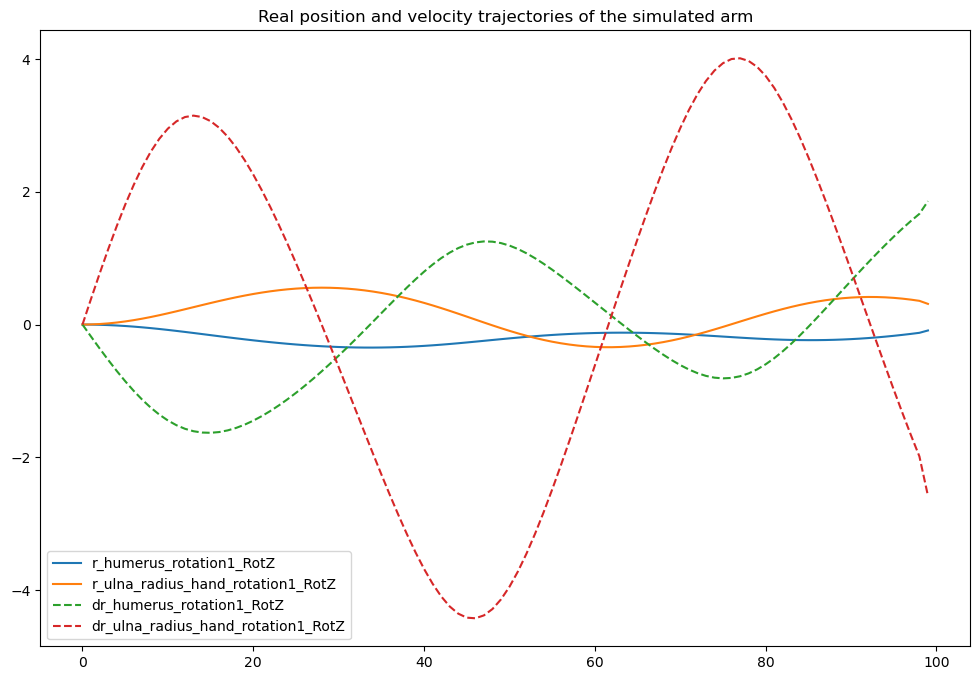

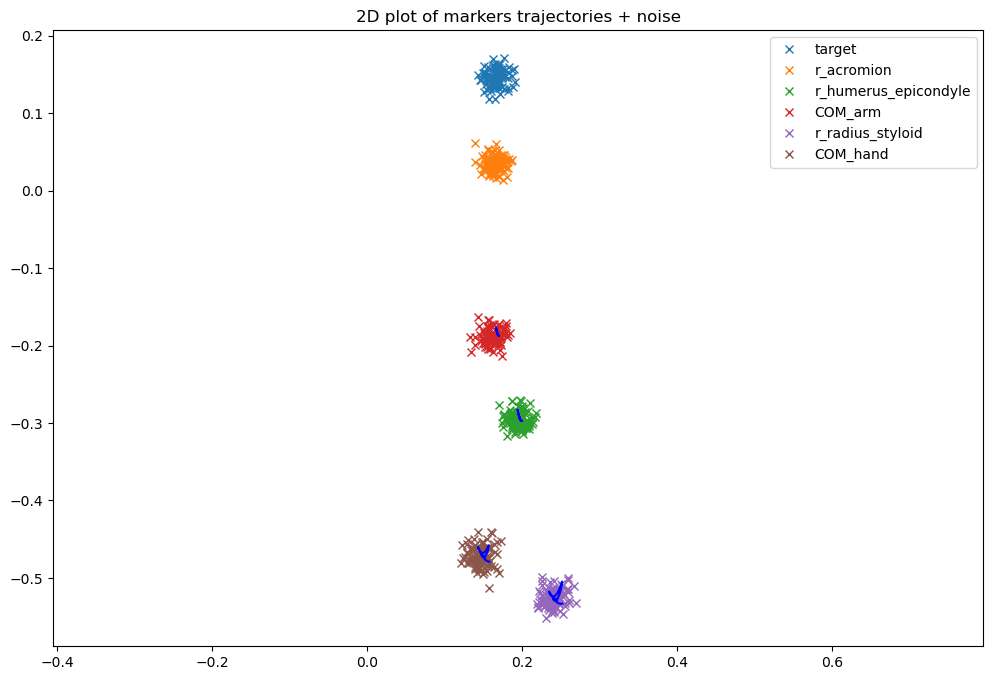

In [12]:
## Let's generate simulated data with our arm model
model = biorbd.Model("models/arm26.bioMod")
nq = model.nbQ()
ndq = model.nbQdot()
ntau = model.nbGeneralizedTorque()
nmark = model.nbMarkers()
tf = 1
n_shoot_per_sec = 100
n_shoot = n_shoot_per_sec*tf
t_max = 2
x0 = np.zeros((nq + ndq,))

# Create a symbolic version of the forward dynamics of the model
q = cas.MX.sym("q", nq)
qdot = cas.MX.sym("qdot", nq)
tau = cas.MX.sym("tau", nq)
qddot_func = biorbd.to_casadi_func("forw_dyn", model.ForwardDynamics, q, qdot, tau)

def arm_ode(t, x, u):
    return np.concatenate((x[nq:, np.newaxis], qddot_func(x[:nq], x[nq:], u)))[:, 0]


# Simulated data
dt = tf / n_shoot
controls = np.zeros((ntau, n_shoot))  # Control trajectory
controls[0, :] = (-np.ones(n_shoot) + np.sin(np.linspace(0, tf, num=n_shoot))) * t_max
states = np.zeros((nq + ndq, n_shoot))  # State trajectory

for n in range(n_shoot):
    sol = solve_ivp(arm_ode, [0, dt], x0, args=(controls[:, n],))
    states[:, n] = x0
    x0 = sol["y"][:, -1]
states[:, -1] = x0
markers = states_to_markers(model, states[:nq, :])

# Simulated noise
np.random.seed(42)
noise_std = 0.01 # 1cm of noise std on each marker
noise = (np.random.randn(3, nmark, n_shoot) - 0.5) * noise_std
markers_noised = markers + noise

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
q_plot = plt.plot(states[:nq, :].T)
dq_plot = plt.plot(states[nq:, :].T, "--")
name_dof = [name.to_string() for name in model.nameDof()]
plt.legend(q_plot + dq_plot, name_dof + ["d" + name for name in name_dof])
plt.title("Real position and velocity trajectories of the simulated arm")

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
marker_plot = plt.plot(markers_noised[2, :, :].T, markers_noised[1, :, :].T, "x")
plt.legend(marker_plot, [i.to_string() for i in model.markerNames()])
plt.gca().set_prop_cycle(None)
plt.plot(markers[2, :, :].T, markers[1, :, :].T, "b")
plt.title("2D plot of markers trajectories + noise")
plt.axis('equal')
plt.show()

Now that we have created this simulated dataset, we can optimize !

In [13]:
model = biorbd.Model("models/arm26.bioMod")
window_len = 10
window_duration = 1 / n_shoot_per_sec * window_len
n_frames_total = tf * n_shoot_per_sec - window_len - 1
x_init = np.zeros((nq * 2, window_len + 1))
u_init = np.zeros((ntau, window_len))
torque_max = 8  # Give a bit of slack on the torque bound

new_objectives = Objective(ObjectiveFcn.Lagrange.MINIMIZE_MARKERS, weight=1000, list_index=0)
mhe = MovingHorizonEstimator(
        model,
        Dynamics(DynamicsFcn.TORQUE_DRIVEN),
        window_len,
        window_duration,
        objective_functions=new_objectives,
        x_init=InitialGuess(x_init, interpolation=InterpolationType.EACH_FRAME),
        u_init=InitialGuess(u_init, interpolation=InterpolationType.EACH_FRAME),
        x_bounds=QAndQDotBounds(model),
        u_bounds=Bounds([-torque_max]*ntau, [torque_max]*ntau),
        n_threads=4,
    )

def update_functions(mhe, t, _):
    def target(i: int):
        return markers_noised[:, :, i : i + window_len + 1]

    mhe.update_objectives_target(target=target(t), list_index=0)
    return t < n_frames_total  # True if there are still some frames to reconstruct

# Solve the program
solver = Solver.ACADOS()
solver.set_maximum_iterations(20)
solver.set_integrator_type("ERK")
solver.set_print_level(1)

sol = mhe.solve(update_functions, solver)



rm -f libacados_ocp_solver_model_2022_10_21_15451460.so
rm -f model_2022_10_21_15451460_cost/model_2022_10_21_15451460_cost_y_0_fun.o model_2022_10_21_15451460_cost/model_2022_10_21_15451460_cost_y_0_fun_jac_ut_xt.o model_2022_10_21_15451460_cost/model_2022_10_21_15451460_cost_y_0_hess.o model_2022_10_21_15451460_cost/model_2022_10_21_15451460_cost_y_fun.o model_2022_10_21_15451460_cost/model_2022_10_21_15451460_cost_y_fun_jac_ut_xt.o model_2022_10_21_15451460_cost/model_2022_10_21_15451460_cost_y_hess.o model_2022_10_21_15451460_cost/model_2022_10_21_15451460_cost_y_e_fun.o model_2022_10_21_15451460_cost/model_2022_10_21_15451460_cost_y_e_fun_jac_ut_xt.o model_2022_10_21_15451460_cost/model_2022_10_21_15451460_cost_y_e_hess.o acados_solver_model_2022_10_21_15451460.o
cc -fPIC -std=c99    -I/home/fb/miniconda3/envs/bioptim_acados/include -I/home/fb/miniconda3/envs/bioptim_acados/include/acados -I/home/fb/miniconda3/envs/bioptim_acados/include/blasfeo/include -I/home/fb/miniconda3/envs/

7	4.033952e-06	4.440026e-07	1.412827e-10	8.613993e-08	0	3	1.000000e+00
8	3.765506e-06	3.934170e-07	4.381954e-10	2.695702e-07	0	3	1.000000e+00
9	3.541539e-06	3.373896e-07	1.633981e-10	9.542976e-08	0	3	1.000000e+00
# it	stat		eq		ineq		comp		qp_stat	qp_iter	alpha
10	3.334403e-06	3.030846e-07	4.279065e-10	2.525734e-07	0	3	1.000000e+00
11	3.155537e-06	2.651594e-07	1.808512e-10	1.028279e-07	0	3	1.000000e+00
12	2.988430e-06	2.404421e-07	4.188427e-10	2.393877e-07	0	3	1.000000e+00
13	2.840825e-06	2.133023e-07	1.950899e-10	1.089283e-07	0	3	1.000000e+00
14	2.701786e-06	1.947302e-07	4.108363e-10	2.287623e-07	0	3	1.000000e+00
15	2.577019e-06	1.745206e-07	2.069989e-10	1.140860e-07	0	3	1.000000e+00
16	2.458692e-06	1.601323e-07	4.037147e-10	2.199598e-07	0	3	1.000000e+00
17	2.351291e-06	1.446303e-07	2.171504e-10	1.185294e-07	0	3	1.000000e+00
18	2.248849e-06	1.332222e-07	3.973348e-10	2.133545e-07	0	3	1.000000e+00
19	2.155074e-06	1.210571e-07	2.259356e-10	1.224133e-07	0	3	1.000000e+00



 ocp_nlp_sqp: m

4	1.802305e-06	1.166630e-07	1.027671e-09	9.443754e-07	0	3	1.000000e+00
5	1.330775e-06	5.351527e-08	9.424044e-10	8.716355e-07	0	3	1.000000e+00
6	6.178008e-07	8.373182e-09	1.212023e-09	9.311917e-07	0	3	1.000000e+00


# it	stat		eq		ineq		comp		qp_stat	qp_iter	alpha
0	1.854884e-01	1.002634e-01	1.591851e+01	9.311917e-07	0	11	1.000000e+00
1	1.540942e-03	4.035599e-02	4.024179e-12	1.361741e-07	0	4	1.000000e+00
2	5.213836e-05	6.451656e-05	5.418412e-09	3.526953e-07	0	3	1.000000e+00
3	4.522865e-06	2.864403e-07	7.139029e-09	9.462546e-07	0	3	1.000000e+00
4	7.669162e-07	2.082004e-08	7.714363e-09	9.389507e-07	0	3	1.000000e+00


# it	stat		eq		ineq		comp		qp_stat	qp_iter	alpha
0	1.642708e-01	6.015333e-02	1.591045e+01	9.389507e-07	0	7	1.000000e+00
1	1.456922e-03	1.649386e-01	4.065197e-14	1.171271e-09	0	4	1.000000e+00
2	1.411344e-04	1.020177e-03	3.808509e-12	8.885302e-09	0	3	1.000000e+00
3	1.466521e-05	5.825531e-06	2.202553e-09	8.044231e-07	0	3	1.000000e+00
4	3.700226e-06	6.408476e-07	2.292363e-10	2.72

ACADOS with Bioptim
Window size of MHE : 0.1 s.
New measurement every : 0.01 s.
Average time per iteration of MHE : 0.013354090091111588 s.
Average real time per iteration of MHE : 0.014071996590907722 s.
Norm of the error on state = 31.706338477401605
6


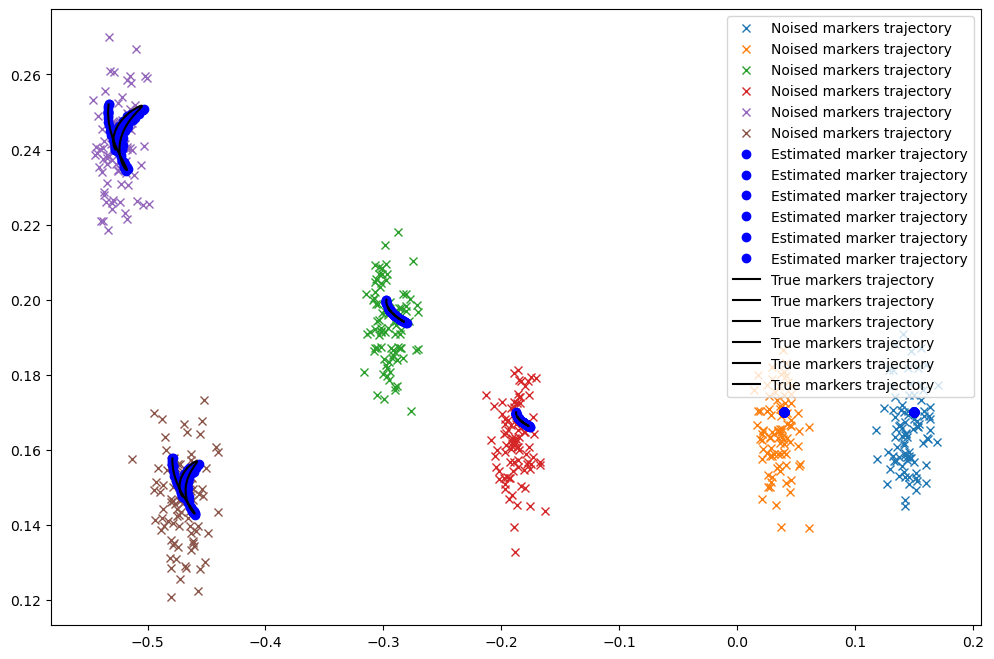

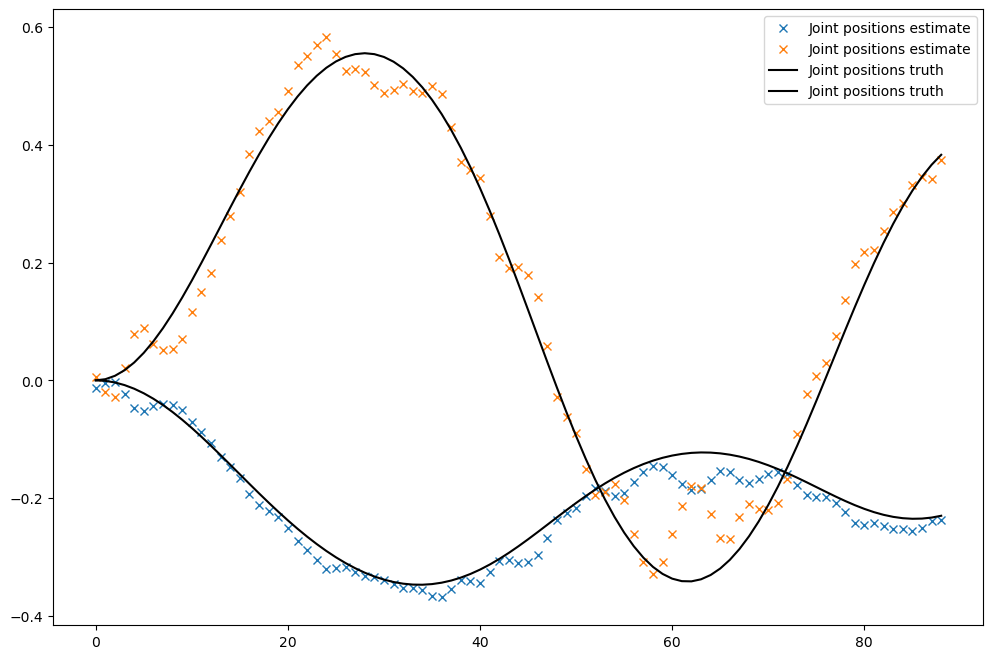

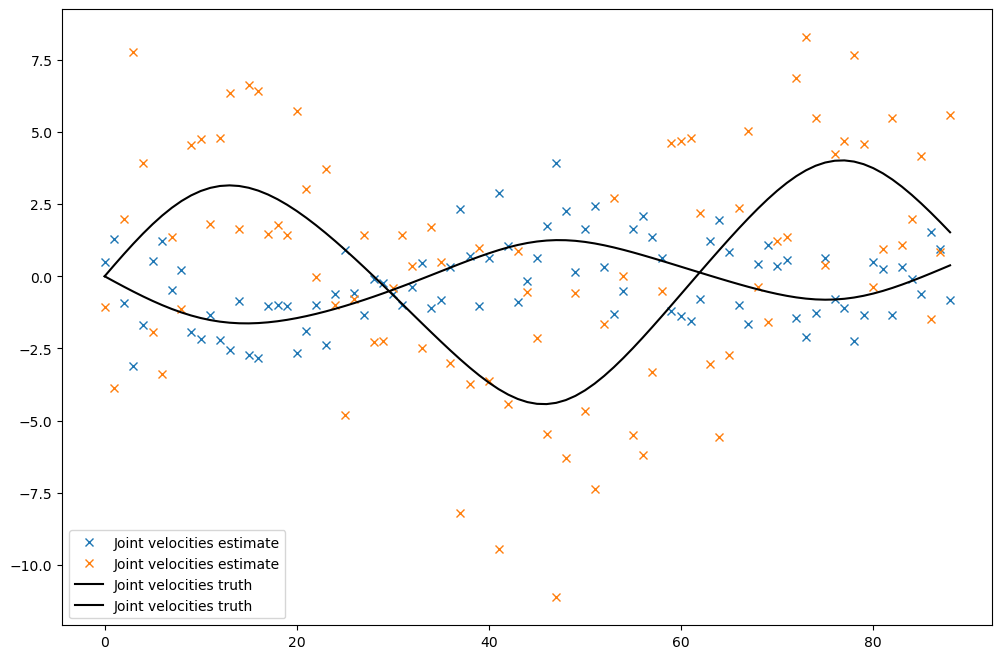

In [14]:
print("ACADOS with Bioptim")
print(f"Window size of MHE : {window_duration} s.")
print(f"New measurement every : {1/n_shoot_per_sec} s.")
print(f"Average time per iteration of MHE : {sol.solver_time_to_optimize/(n_frames_total - 1)} s.")
print(f"Average real time per iteration of MHE : {sol.real_time_to_optimize/(n_frames_total - 1)} s.")
print(f"Norm of the error on state = {np.linalg.norm(states[:,:n_frames_total] - sol.states['all'])}")

markers_estimated = states_to_markers(model, sol.states["all"])

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(
    markers_noised[1, :, :n_frames_total].T,
    markers_noised[2, :, :n_frames_total].T,
    "x",
    label="Noised markers trajectory",
)
plt.plot(markers_estimated[1, :, :].T, markers_estimated[2, :, :].T, "bo", label="Estimated marker trajectory")
plt.plot(markers[1, :, :n_frames_total].T, markers[2, :, :n_frames_total].T, 'k', label="True markers trajectory")
plt.legend()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(sol.states["q"].T, "x", label="Joint positions estimate")
plt.gca().set_prop_cycle(None)
plt.plot(states[:nq, :n_frames_total].T, 'k', label="Joint positions truth")
plt.legend()
plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(sol.states["qdot"].T, "x", label="Joint velocities estimate")
plt.gca().set_prop_cycle(None)
plt.plot(states[nq:, :n_frames_total].T, 'k',label="Joint velocities truth")
plt.legend()
plt.show()